In [1]:
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt
from timeit import default_timer as timer

**Import Dataset**

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/atreish/AIM_5007_Neural_Networks_-_Deep_Learning/main/seeds_dataset.txt',
                   sep='\s+',header=None, names = ['Area','Perimeter','Compactness','Klength','Kwidth','Asym_coeff','length of kernel groove','class_label'])
data.head(5)

,Area,Perimeter,Compactness,Klength,Kwidth,Asym_coeff,length of kernel groove,class_label
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


**Data Cleaning**

In [3]:
#Normalize Numeric Data, Not the label column
data.iloc[:,:-1] = data.iloc[:,:-1].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

#Shuffle the dataset to ensure the network is trained on all 3 available classes
data1 = data.sample(frac=1).reset_index(drop=True)

#Change X  (numeric columns) and y (class columns) to arrays and the target datatype to int
X = np.array(data1)[:, :-1]
y = np.array(data1)[:, -1].astype(int)

#Apply one hot encoding for each class, this will be our target class 
target_layer = []
for i in y:
    if i == 1:
        target_layer.append([1,0,0])
    elif i == 2:
        target_layer.append([0,1,0])
    else:
        i == 3
        target_layer.append([0,0,1])
        
target_layer = np.array(target_layer)

#Train-test split 150/60
X_train = X[:150]
X_test = X[150:]
y_train = target_layer[:150]
y_test = target_layer[150:]

In [4]:
X_train.shape

(150, 7)

In [5]:
y_train.shape

(150, 3)

**Neural Network Functions**

In [9]:
'''Activation Function for this network'''

def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

'''Append the entire matrix with a column of ones for the bias node'''

def append(X):
    height = X.shape[0] 
    bias_column = np.ones((height,1))
    X_appended = np.hstack((X,bias_column))
    return X_appended

'''Initializes a Weight Matrix from the input layer to the hidden layer using the length of a single row 
for argument Matrix X'''

def w_input(X):
    X_appended = append(X)
    rows = len(X[0]) 
    cols = len(X[0])
    W = np.random.sample((cols, rows)) - 0.5
    random_bias_weight = np.random.sample()
    bias_row = np.repeat(random_bias_weight, rows)
    W_input = np.insert(W, cols, bias_row, axis=0)
    return W_input

'''This is the dot product between a weight matrix and the appended X matrix (one row at a time), this returns
an unactivated hidden layer of length 7, as specified by the dimensions of the problem'''

def h_raw(X,i,weight1=None): 
    if weight1 is None:
        weight1 = w_input(X)
    X_appended_row = append(X)[i]
    hraw = np.dot(X_appended_row, weight1)
    return hraw, weight1

'''This function now activates the hidden layer by applying the sigmoid activation function and returns the 
weight that was used to get from the input layer to the hidden layer'''

def h_activated(X,i,weight1=None):
    hidden_layer_raw, weight1 = h_raw(X,i,weight1)
    hactivated = sigmoid(hidden_layer_raw)
    return hactivated, weight1

'''Initializes a Weight Matrix for the hidden to output layer using the length of the activated hidden layer,
this also appends a random weight at the bottom of the matrix for the bias from hidden to output layer'''

def w_output(X, i, y_train, weight1=None):
    hactivated, _ = h_activated(X,i,weight1=weight1)
    rows = len(hactivated)
    W = np.random.sample((rows, 3)) - 0.5
    random_weight = np.random.sample([1]) - 0.5
    weight_vector = np.repeat(random_weight,3)
    W_output = np.insert(W, rows, weight_vector, axis=0)
    return W_output

'''This is the dot product between an appended activated hidden layer and W_output, this gives us the first
output layer values'''

def o_raw(X,i, weight1=None, weight2=None):
    hactivated, weight1 = h_activated(X, i , weight1)
    h_activated_with_bias = np.append(hactivated,[1]) 
    if weight2 is None:
        weight2 = w_output(X,i,weight1)
    oraw = np.dot(h_activated_with_bias, weight2)
    return oraw, weight2

'''This function now activates the output layer by applying the sigmoid activation function and returns the 
weight that was used to get from the hidden layer to the output layer'''

def o_activated(X,i, weight1=None, weight2=None):
    oraw, weight2 = o_raw(X,i, weight1=weight1, weight2=weight2)
    oactivated = sigmoid(oraw)
    return oactivated, weight2

'''This Error function determines the error of the output for the i-th row of the Matrix and the i-th target layer
and outputs a single value that will be used in the backpropogation steps'''

def error(X,y,i,weight1=None, weight2=None):
    oactivated, _ = o_activated(X, i, weight1=weight1, weight2=weight2)
    error = .5*((y[i] - oactivated)**2).sum()
    return error

'''The Feedforward Steps all conglomerated into one function from X matrix row to output activated. This catch-all
function will return the outputlayer actived for the i-th row, the weight matricies used form both the input layer
to hidden layer and from the hidden layer to the input layer and the associated erro'''

def feedforward(X, y, i, weight1=None, weight2=None):
    hactivated, weight1 = h_activated(X,i, weight1)
    oactivated, weight2 = o_activated(X,i, weight1=weight1, weight2=weight2)
    err = error(X,y,i,weight1=weight1, weight2=weight2)
    return oactivated, hactivated, err, weight1, weight2

'''First Step in Backpropogation, this produces the Gradient Matrix from the Hidden Layer to the
Output Layer (8x3)'''

def grad_hidden_to_output(X,y,i, oactivated, hactivated): 
    E = (oactivated - y[i]) * oactivated * (1 - oactivated)
    h_activated_transpose = np.array([[i] for i in hactivated])
    grad_hidden_to_output = h_activated_transpose * E 
    bias_gradient = ((oactivated - y[i]) * oactivated * (1 - oactivated)).sum()
    bias_h2o =  np.array([bias_gradient])
    len_bias_row = grad_hidden_to_output.shape[1]
    BG_H_O = np.repeat(bias_h2o[0],len_bias_row)
    hidden_to_output_gradient_matrix = np.vstack([grad_hidden_to_output, BG_H_O])
    return hidden_to_output_gradient_matrix

'''The Gradient Matrix from the Input Layer to the Hidden Layer (8x7)'''

def grad_input_to_hidden(X, y, i, oactivated, hactivated, W_output):
    input_layer = X[i]
    target_layer = y[i]
    W_output_wo_bias = W_output[:-1,:] 
    E = (oactivated - target_layer) * oactivated * (1 - oactivated) 
    grad_input_to_hidden = np.zeros((7,7))
    for j in range(len(hactivated)):
        pt1 = []  
        pt2 = []
        pt1.append( np.dot(E, W_output_wo_bias[j]) ) 
        pt2.append( hactivated[j] * (1 - hactivated[j])) 
        grad_input_to_hidden[:,j] = np.array(pt1) * np.array(pt2) * input_layer
    pt3 = np.dot(E, W_output_wo_bias.T)
    pt4 = hactivated *(1-hactivated)
    bias_gradient_il = np.dot(pt3,pt4)
    len_bias_row = hactivated.shape[0]
    BG_I_H = np.repeat(bias_gradient_il, len_bias_row)
    input_to_hidden_gradient_matrix = np.vstack((grad_input_to_hidden, BG_I_H))
    return input_to_hidden_gradient_matrix

'''Updated Weights from the Input to Hidden Layer with learning rate lr'''

def update_input_hidden_weights(X,y,i,lr, oactivated, hactivated, weight1=None, weight2=None):
    input_to_hidden_gradient_matrix = grad_input_to_hidden(X, y, i, oactivated, hactivated, weight2)
    updated_weights_input_hidden = weight1 - lr * input_to_hidden_gradient_matrix
    return updated_weights_input_hidden

'''Updated Weights for Hidden to Output Layer with lr'''

def update_hidden_output_weights(X,y,i,lr, oactivated, hactivated, weight2=None):
    hidden_to_output_gradient_matrix =  grad_hidden_to_output(X,y,i, oactivated, hactivated)
    updated_weights_hidden_output = weight2 - lr * hidden_to_output_gradient_matrix
    return updated_weights_hidden_output

'''Backpropogation Function'''

def backpropogation(X,y,i,lr,oactivated,hactivated,weight1=None, weight2=None):
    updated_weight1 = update_input_hidden_weights(X,y,i,lr, oactivated, hactivated, weight1=weight1, weight2=weight2)
    updated_weight2 = update_hidden_output_weights(X,y,i,lr, oactivated, hactivated, weight2)
    oactivated1, hactivated1, err, updated_weight1, updated_weight2 = feedforward(X, y, i, weight1=updated_weight1, weight2=updated_weight2)
    return err, oactivated1, updated_weight1, updated_weight2

'''Transforms the Rows of all oactivated1 to one hot encoding to compare with y_trian'''

def output_encoder(Matrix):
    for row in Matrix:
        row[row.argmax(0)] = 1
        row[row < 1] = 0
    return Matrix

'''Creates a visualization of the Errors'''

def error_plotter(Matrix,threshold): 
    result = np.array(list(map(sum, Matrix))) / len(Matrix[0])
    index = np.array(list(range(len(result))))
    Ezz = np.vstack((index+1, result)).T
    x = Ezz[:,0]
    y = Ezz[:,1]
    plt.figure(figsize=(16,5))
    plt.plot(x,y)
    plt.axhline(y=threshold, color='r', linestyle='--')
    plt.show

**Neural Network Training Function**

In [63]:
'''This Neural Network Training function will apply our defined functions above to the dataset of our choice.
The seeds data has already been shuffled and split. In this function, we will iterate through the rows of our
Matrix input, forward-propograte and then backward-propogate, obtain updated weights and then apply the forward
propogation again to the same row, that is for each row. At every stage,  '''

def nn_training(X, y, lr, threshold=.001, epoch_count=1000):
    start = timer()
    wt1 = None
    wt2 = None
    final_output = []
    errors = [] 
    
    for n in range(epoch_count):
        
        M = np.concatenate((X_train, y_train), axis=1)
        M = pd.DataFrame(M)
        M1 = M.sample(frac=1).reset_index(drop=True)
        XX_train = np.array(M1.iloc[:,:7])
        yy_train = np.array(M1.iloc[:,7:])
        
        avg_error = []       
        for i in range(XX_train.shape[0]):  
            oact, hact, err, wt1, wt2 = feedforward(XX_train,yy_train,i,weight1=wt1, weight2=wt2)
            err, oactivated1, updated_weight1, updated_weight2 = backpropogation(XX_train,yy_train,i,lr,oactivated=oact,hactivated=hact,weight1=wt1, weight2=wt2)
            wt1 = updated_weight1
            wt2 = updated_weight2
            final_output.append(oactivated1)
            errors.append(err)
            avg_error.append(err)
    #    if np.array(avg_error).mean() < threshold:
    #        break
     #       return error_plotter2(avg_error.mean(),threshold)
    
    epoch_errors = np.reshape(errors,(epoch_count, len(X)))
    normalized_errors = np.array(list(map(sum,  epoch_errors))) / len( epoch_errors[0])
    error_plotter(epoch_errors,threshold)
    
    output = np.asarray(final_output[-len(X):])
    encoded_output = output_encoder(output)      
    tot = np.sum(np.all(encoded_output == yy_train, axis=1))
    accuracy = tot/len(y_train)

    end = timer()
    time_elspased = end-start
    
    print('\nAfter {} epochs, the accuracy is {}%'.format(epoch_count,round(accuracy*100, 2)))
    print('\nTime Used for this function {} seconds'.format(round(time_elspased,2)))
    print('\nFinal Error = {}'.format(round(normalized_errors[-1],5)))
    print('\nFinal Input Layer to Hidden Layer Weights:\n\n{}'.format(wt1))
    print('\n\nFinal Hidden Layer to Output Layer Weights:\n\n{}'.format(wt2))
    
    return 


After 3000 epochs, the accuracy is 100.0%

Time Used for this function 414.79 seconds

Final Error = 0.00126

Final Input Layer to Hidden Layer Weights:

[[ 0.42921828 -2.66524711  1.19818713 -1.51536613 -4.42580162 -2.02583819
  -8.09253752]
 [ 0.66475767 -2.33187799  0.83218281 -2.00122838 -3.89710475 -1.54981842
  -9.62880575]
 [-0.22923743  1.34537326 -1.38403856 -0.86402761  4.3868439   1.05056251
   0.84785982]
 [-0.63459638  5.89125631 -2.20574868  1.66612353 11.55205683  9.77342735
  -7.21960652]
 [ 0.80790807 -2.50173193  0.51124751 -1.80902167 -3.16397669 -1.08687541
  -7.47020664]
 [-1.68943276 -0.50452941 -3.40436241  0.17918559 -3.58174553 -6.16661982
   5.18432531]
 [ 0.60698823 -4.10130766  2.21559746 -2.61152821 -7.74766857 -8.24071259
   9.77743214]
 [ 2.57993327  2.57993327  2.57993327  2.57993327  2.57993327  2.57993327
   2.57993327]]


Final Hidden Layer to Output Layer Weights:

[[ -4.74221523   6.18615374  -1.82620772]
 [  5.79961613  -4.46954369   1.09292891]
 

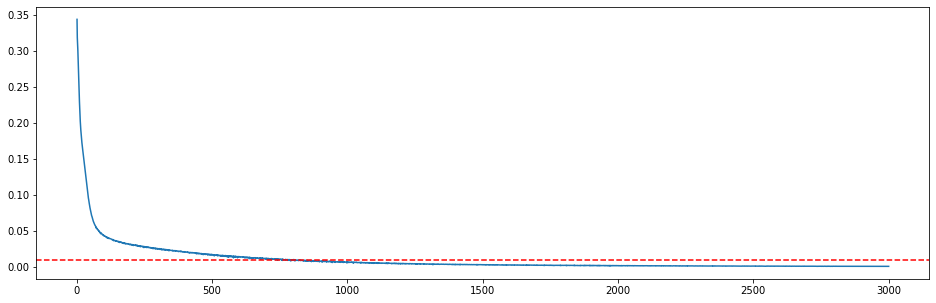

In [65]:
'''Apply the above training program using defined functions to the provided X_train and y_train data. This data
is length 150. After running we will have time spent running, accuracy, final Error (from ALL errors),
a visualization of the mean of the Error for every epoch, in this case 3000 and the Weight Matricies to be used 
on the testing set. The point of the visualization is to determine from the datapoints plotted if the Error 
indeed seems to be heading downward or there is no real change'''

nn_training(X_train, y_train, lr=.1, threshold=.01, epoch_count=3000)

**Neural Network Testing Function**

In [66]:
'''The following code will be very similar to our training data, however here we will input the weights obtained
above by the Training Function after 3000 epochs. These weights will ideally have allow our testing dataset's 
error to converge rapidly to the threshold. Testing is a bit different, firstly, only the feedforward 
function is applied to the datapoint (rows) of our testing dataframe. Accuracy is determined for the activated
output layer. As before the metric for testing the output layer with our y_test is the label encoder which applies
a 1 to the highest value and a 0 to others. This mimics the one hot encoding application done to the classes 
that are held in the dataframe. If the activated-output layer matches the y_test row, it is a match. This entire
testing function is applied ONCE to the validation dataset, there are no epochs in testing. The intent here is
to return an accuracy metric and timer for the weights provided by the above training function'''

def nn_testing(X, y):
    start = timer()
    
    wt1 = np.array([[ 0.42921828, -2.66524711,  1.19818713, -1.51536613, -4.42580162, -2.02583819,
  -8.09253752],
 [ 0.66475767, -2.33187799,  0.83218281, -2.00122838, -3.89710475, -1.54981842,
  -9.62880575],
 [-0.22923743,  1.34537326, -1.38403856, -0.86402761,  4.3868439,   1.05056251,
   0.84785982],
 [-0.63459638,  5.89125631, -2.20574868,  1.66612353, 11.55205683,  9.77342735,
  -7.21960652],
 [ 0.80790807, -2.50173193,  0.51124751, -1.80902167, -3.16397669, -1.08687541,
  -7.47020664],
 [-1.68943276, -0.50452941, -3.40436241,  0.17918559, -3.58174553, -6.16661982,
   5.18432531],
 [ 0.60698823, -4.10130766,  2.21559746, -2.61152821, -7.74766857, -8.24071259,
   9.77743214],
 [ 2.57993327,  2.57993327,  2.57993327,  2.57993327,  2.57993327,  2.57993327,
   2.57993327]])
    
    wt2 = np.array([[ -4.74221523,   6.18615374,  -1.82620772],
 [  5.79961613,  -4.46954369,   1.09292891],
 [ -6.70918087,   6.63861363,  -2.18812044],
 [  1.60526833,  -2.70164446,   0.28253794],
 [ 10.49585249, -10.38727524,  -2.34993075],
 [  8.37979786,  -7.9409275,   -6.21367849],
 [-13.2194537,   -4.91282617,  13.69378793],
 [ -0.98751585,  -0.98751585,  -0.98751585]])
    
    final_output = []
    errors = [] 
    for i in range(X.shape[0]):  
        oact, hact, err, wt1, wt2 = feedforward(X,y,i,weight1=wt1, weight2=wt2)
        final_output.append(oact)
        errors.append(err)
    output = np.asarray(final_output[-len(X):])
    encoded_output = output_encoder(output)      
    tot = np.sum(np.all(encoded_output == y_test, axis=1))
    accuracy = tot/len(y_test)
    end = timer()
    time_elspased = end-start
    print('\nThe accuracy is {}%'.format(round(accuracy*100, 2)))
    print('\nTime Used for this function {} seconds'.format(round(time_elspased,2)))
    return

In [68]:
nn_testing(X_test, y_test)


The accuracy is 91.67%

Time Used for this function 0.01 seconds
